這個HW3＿3是使用 EfficientNet-B0 作為特徵提取器，並加上一個自訂的分類頭（classifier）來進行五類的分類任務。

使用的數據集是Metal_nut，good種類的資料很多與其他種類數量極度不平衡

In [9]:
import glob
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm
import cv2
import numpy as np

In [10]:
import os

base_path = "/Users/adam0725/1332/1233/Pratice/train"

image_label_pairs = []

for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.endswith(".png"):
            full_path = os.path.join(root, file)
            class_folder = os.path.basename(os.path.dirname(full_path))
            label = 0 if "good" in class_folder.lower() else 1
            image_label_pairs.append((full_path, label))

# 顯示前幾筆確認
print("共載入圖片數量：", len(image_label_pairs))
print("前 3 筆：", image_label_pairs[:3])

共載入圖片數量： 313
前 3 筆： [('/Users/adam0725/1332/1233/Pratice/train/bent_2/002.png', 1), ('/Users/adam0725/1332/1233/Pratice/train/bent_2/016.png', 1), ('/Users/adam0725/1332/1233/Pratice/train/bent_2/017.png', 1)]


In [11]:
import cv2
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# 讀入所有影像與標籤
all_images = []
all_labels = []

for path, label in image_label_pairs:
    img = cv2.imread(path)
    img = cv2.resize(img, (224, 224))  # 
    img = img[..., ::-1]  # BGR → RGB
    # img = img.astype(np.float32) / 255.0  
    all_images.append(img)
    all_labels.append(label)

# 轉為 tensor
x = torch.tensor(np.array(all_images)).permute(0, 3, 1, 2)  # N, C, H, W
y = torch.tensor(all_labels).float().unsqueeze(1)  # N, 1

# 切分訓練/驗證集（7:3）
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)

# 包裝為 DataLoader
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Classes: ['bent_2', 'color_2', 'flip_2', 'good', 'scratch_2']


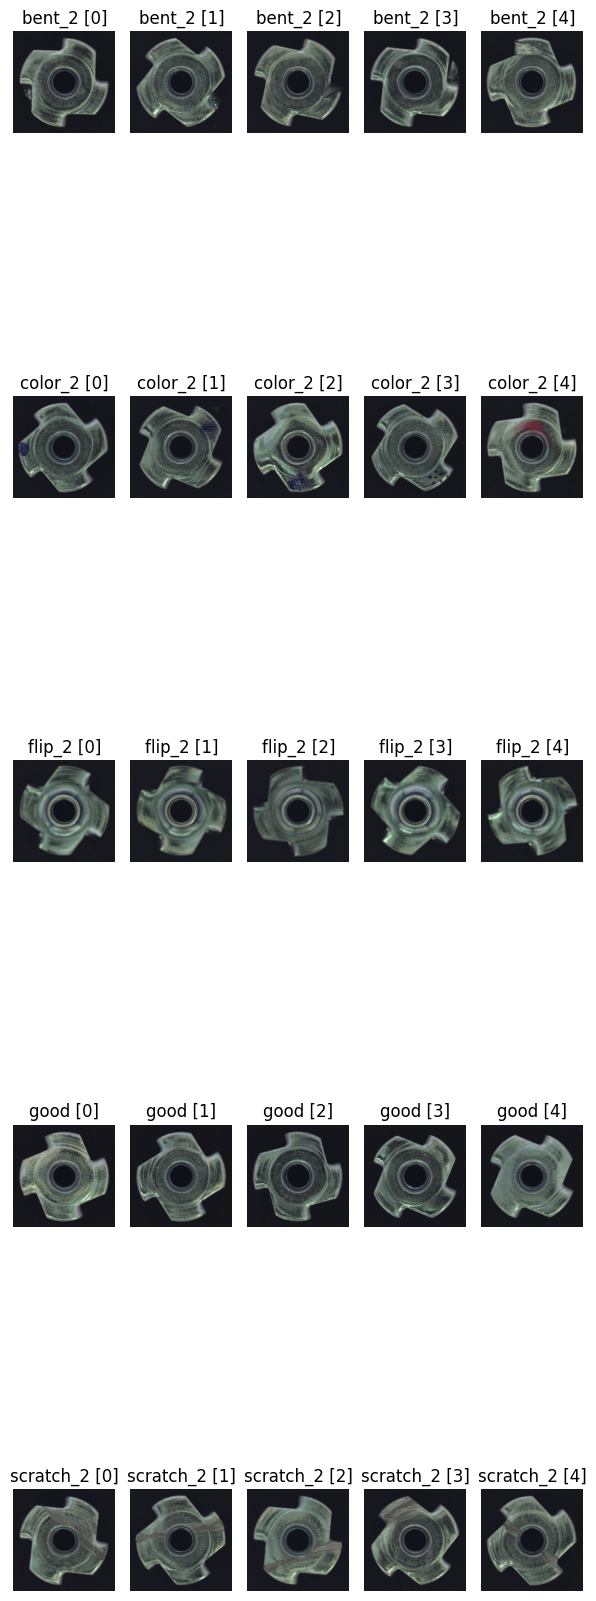

In [12]:
import matplotlib.pyplot as plt


class_names = sorted(set([os.path.basename(os.path.dirname(p)) for p, _ in image_label_pairs]))
print(f'Classes: {class_names}')

img_per_class = 5
fig, axs = plt.subplots(len(class_names), img_per_class, figsize=(6, 4 * len(class_names)))


for i, class_name in enumerate(class_names):
    
    class_indices = [idx for idx, (path, _) in enumerate(image_label_pairs) if class_name in path]

    for j in range(img_per_class):
        img = all_images[class_indices[j]]
        ax = axs[i, j] if len(class_names) > 1 else axs[j]
        ax.imshow(img)
        ax.set_title(f'{class_name} [{j}]')
        ax.axis('off')

plt.tight_layout()
plt.show()

In [13]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np

num_classes = 5
images_per_class = 10
train_images_per_class = int(images_per_class * 0.8)
val_images_per_class = int(images_per_class * 0.2)

x_train = []
x_val = []

for i in range(num_classes):
    start_index = i * images_per_class
    x_train.extend(all_images[start_index:start_index + train_images_per_class])
    x_val.extend(all_images[start_index + train_images_per_class:start_index + images_per_class])

# The shape changes from (batch_size, height, width, channels) to (batch_size, channels, height, width)
x_train = np.transpose(np.array(x_train), (0, 3, 1, 2))
x_val = np.transpose(np.array(x_val), (0, 3, 1, 2))

y_train = np.concatenate([np.full(train_images_per_class, i) for i in range(num_classes)])
y_val = np.concatenate([np.full(val_images_per_class, i) for i in range(num_classes)])

print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_val: {x_val.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_val: {y_val.shape}')

Shape of x_train: (40, 3, 224, 224)
Shape of x_val: (10, 3, 224, 224)
Shape of y_train: (40,)
Shape of y_val: (10,)


In [14]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

train_transforms = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.AutoAugment(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ]
)

class MyDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = torch.from_numpy(y).long()
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        img = self.x[idx]
        print(f'idx: {idx}, img.shape: {img.shape}, img.dtype: {img.dtype}')  # Debug 重點！

        img_array = np.transpose(img, (1, 2, 0))  # shape: (H, W, 3)
        img_array = np.clip(img_array * 255, 0, 255).astype('uint8')

        if img_array.shape != (224, 224, 3):
            print(f'[WARNING] Unexpected shape: {img_array.shape} (index {idx})')
            img_array = np.zeros((224, 224, 3), dtype='uint8')

        image = Image.fromarray(img_array)

        if self.transform:
            image = self.transform(image)

        label = int(self.y[idx])
        return image, label

In [15]:
batch_size = 8

train_dataset = MyDataset(x_train, y_train, train_transforms)
val_dataset = MyDataset(x_val, y_val, val_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0,pin_memory=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=0,pin_memory=False)

In [16]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchvision.models import efficientnet_b0

model = efficientnet_b0(weights='IMAGENET1K_V1')

# ConvNet as fixed feature extractor (freeze parameters)
for param in model.parameters():
    param.requires_grad = False


num_class = 5

# change # of class from 1000 into 8 in the last layer
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_class)
)
print(model)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [17]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 20


model = model  

best_val_loss = float('inf')
best_val_acc = -1

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
     
        
        optimizer.zero_grad()
        outputs = model(images)
        labels = labels.long()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = outputs.argmax(-1)
        train_correct += (train_predicted == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
         
            #images = images / 255.
        
            outputs = model(images)
            labels = labels.long()

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = outputs.argmax(-1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'model_classification.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.4f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.4f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)


  0%|          | 0/20 [00:00<?, ?it/s]

idx: 24, img.shape: (3, 224, 224), img.dtype: uint8
idx: 2, img.shape: (3, 224, 224), img.dtype: uint8
idx: 10, img.shape: (3, 224, 224), img.dtype: uint8
idx: 14, img.shape: (3, 224, 224), img.dtype: uint8
idx: 0, img.shape: (3, 224, 224), img.dtype: uint8
idx: 28, img.shape: (3, 224, 224), img.dtype: uint8
idx: 21, img.shape: (3, 224, 224), img.dtype: uint8
idx: 12, img.shape: (3, 224, 224), img.dtype: uint8
idx: 5, img.shape: (3, 224, 224), img.dtype: uint8
idx: 11, img.shape: (3, 224, 224), img.dtype: uint8
idx: 37, img.shape: (3, 224, 224), img.dtype: uint8
idx: 29, img.shape: (3, 224, 224), img.dtype: uint8
idx: 13, img.shape: (3, 224, 224), img.dtype: uint8
idx: 6, img.shape: (3, 224, 224), img.dtype: uint8
idx: 35, img.shape: (3, 224, 224), img.dtype: uint8
idx: 1, img.shape: (3, 224, 224), img.dtype: uint8
idx: 20, img.shape: (3, 224, 224), img.dtype: uint8
idx: 38, img.shape: (3, 224, 224), img.dtype: uint8
idx: 31, img.shape: (3, 224, 224), img.dtype: uint8
idx: 3, img.shape

  5%|▌         | 1/20 [00:00<00:15,  1.23it/s]

Epoch 1/20, Train loss: 2.6286, Train acc: 17.5000%, Val loss: 4.6589, Val acc: 20.0000%, Best Val loss: 4.6589 Best Val acc: 20.00%
idx: 0, img.shape: (3, 224, 224), img.dtype: uint8
idx: 14, img.shape: (3, 224, 224), img.dtype: uint8
idx: 5, img.shape: (3, 224, 224), img.dtype: uint8
idx: 1, img.shape: (3, 224, 224), img.dtype: uint8
idx: 16, img.shape: (3, 224, 224), img.dtype: uint8
idx: 29, img.shape: (3, 224, 224), img.dtype: uint8
idx: 6, img.shape: (3, 224, 224), img.dtype: uint8
idx: 13, img.shape: (3, 224, 224), img.dtype: uint8
idx: 9, img.shape: (3, 224, 224), img.dtype: uint8
idx: 17, img.shape: (3, 224, 224), img.dtype: uint8
idx: 10, img.shape: (3, 224, 224), img.dtype: uint8
idx: 2, img.shape: (3, 224, 224), img.dtype: uint8
idx: 25, img.shape: (3, 224, 224), img.dtype: uint8
idx: 21, img.shape: (3, 224, 224), img.dtype: uint8
idx: 22, img.shape: (3, 224, 224), img.dtype: uint8
idx: 35, img.shape: (3, 224, 224), img.dtype: uint8
idx: 12, img.shape: (3, 224, 224), img.dt

 10%|█         | 2/20 [00:01<00:13,  1.32it/s]

idx: 0, img.shape: (3, 224, 224), img.dtype: uint8
idx: 1, img.shape: (3, 224, 224), img.dtype: uint8
idx: 2, img.shape: (3, 224, 224), img.dtype: uint8
idx: 3, img.shape: (3, 224, 224), img.dtype: uint8
idx: 4, img.shape: (3, 224, 224), img.dtype: uint8
idx: 5, img.shape: (3, 224, 224), img.dtype: uint8
idx: 6, img.shape: (3, 224, 224), img.dtype: uint8
idx: 7, img.shape: (3, 224, 224), img.dtype: uint8
idx: 8, img.shape: (3, 224, 224), img.dtype: uint8
idx: 9, img.shape: (3, 224, 224), img.dtype: uint8
Epoch 2/20, Train loss: 3.1770, Train acc: 22.5000%, Val loss: 6.9820, Val acc: 20.0000%, Best Val loss: 4.6589 Best Val acc: 20.00%
idx: 16, img.shape: (3, 224, 224), img.dtype: uint8
idx: 29, img.shape: (3, 224, 224), img.dtype: uint8
idx: 32, img.shape: (3, 224, 224), img.dtype: uint8
idx: 35, img.shape: (3, 224, 224), img.dtype: uint8
idx: 28, img.shape: (3, 224, 224), img.dtype: uint8
idx: 3, img.shape: (3, 224, 224), img.dtype: uint8
idx: 39, img.shape: (3, 224, 224), img.dtype: 

 15%|█▌        | 3/20 [00:02<00:15,  1.10it/s]

idx: 8, img.shape: (3, 224, 224), img.dtype: uint8
idx: 9, img.shape: (3, 224, 224), img.dtype: uint8
Epoch 3/20, Train loss: 3.0125, Train acc: 35.0000%, Val loss: 3.1534, Val acc: 20.0000%, Best Val loss: 3.1534 Best Val acc: 20.00%
idx: 24, img.shape: (3, 224, 224), img.dtype: uint8
idx: 1, img.shape: (3, 224, 224), img.dtype: uint8
idx: 37, img.shape: (3, 224, 224), img.dtype: uint8
idx: 32, img.shape: (3, 224, 224), img.dtype: uint8
idx: 23, img.shape: (3, 224, 224), img.dtype: uint8
idx: 3, img.shape: (3, 224, 224), img.dtype: uint8
idx: 35, img.shape: (3, 224, 224), img.dtype: uint8
idx: 5, img.shape: (3, 224, 224), img.dtype: uint8
idx: 6, img.shape: (3, 224, 224), img.dtype: uint8
idx: 22, img.shape: (3, 224, 224), img.dtype: uint8
idx: 19, img.shape: (3, 224, 224), img.dtype: uint8
idx: 15, img.shape: (3, 224, 224), img.dtype: uint8
idx: 20, img.shape: (3, 224, 224), img.dtype: uint8
idx: 18, img.shape: (3, 224, 224), img.dtype: uint8
idx: 31, img.shape: (3, 224, 224), img.dt

 20%|██        | 4/20 [00:03<00:14,  1.09it/s]

Epoch 4/20, Train loss: 2.6552, Train acc: 32.5000%, Val loss: 1.9284, Val acc: 20.0000%, Best Val loss: 1.9284 Best Val acc: 20.00%
idx: 34, img.shape: (3, 224, 224), img.dtype: uint8
idx: 18, img.shape: (3, 224, 224), img.dtype: uint8
idx: 6, img.shape: (3, 224, 224), img.dtype: uint8
idx: 10, img.shape: (3, 224, 224), img.dtype: uint8
idx: 26, img.shape: (3, 224, 224), img.dtype: uint8
idx: 35, img.shape: (3, 224, 224), img.dtype: uint8
idx: 29, img.shape: (3, 224, 224), img.dtype: uint8
idx: 0, img.shape: (3, 224, 224), img.dtype: uint8
idx: 7, img.shape: (3, 224, 224), img.dtype: uint8
idx: 27, img.shape: (3, 224, 224), img.dtype: uint8
idx: 33, img.shape: (3, 224, 224), img.dtype: uint8
idx: 23, img.shape: (3, 224, 224), img.dtype: uint8
idx: 1, img.shape: (3, 224, 224), img.dtype: uint8
idx: 15, img.shape: (3, 224, 224), img.dtype: uint8
idx: 13, img.shape: (3, 224, 224), img.dtype: uint8
idx: 4, img.shape: (3, 224, 224), img.dtype: uint8
idx: 25, img.shape: (3, 224, 224), img.d

 25%|██▌       | 5/20 [00:04<00:13,  1.10it/s]

idx: 8, img.shape: (3, 224, 224), img.dtype: uint8
idx: 9, img.shape: (3, 224, 224), img.dtype: uint8
Epoch 5/20, Train loss: 2.6757, Train acc: 25.0000%, Val loss: 2.2791, Val acc: 20.0000%, Best Val loss: 1.9284 Best Val acc: 20.00%
idx: 30, img.shape: (3, 224, 224), img.dtype: uint8
idx: 7, img.shape: (3, 224, 224), img.dtype: uint8
idx: 14, img.shape: (3, 224, 224), img.dtype: uint8
idx: 10, img.shape: (3, 224, 224), img.dtype: uint8
idx: 24, img.shape: (3, 224, 224), img.dtype: uint8
idx: 32, img.shape: (3, 224, 224), img.dtype: uint8
idx: 22, img.shape: (3, 224, 224), img.dtype: uint8
idx: 33, img.shape: (3, 224, 224), img.dtype: uint8
idx: 23, img.shape: (3, 224, 224), img.dtype: uint8
idx: 38, img.shape: (3, 224, 224), img.dtype: uint8
idx: 37, img.shape: (3, 224, 224), img.dtype: uint8
idx: 21, img.shape: (3, 224, 224), img.dtype: uint8
idx: 19, img.shape: (3, 224, 224), img.dtype: uint8
idx: 28, img.shape: (3, 224, 224), img.dtype: uint8
idx: 29, img.shape: (3, 224, 224), img

 30%|███       | 6/20 [00:05<00:12,  1.09it/s]

Epoch 6/20, Train loss: 2.3223, Train acc: 32.5000%, Val loss: 1.8033, Val acc: 30.0000%, Best Val loss: 1.8033 Best Val acc: 30.00%
idx: 18, img.shape: (3, 224, 224), img.dtype: uint8
idx: 8, img.shape: (3, 224, 224), img.dtype: uint8
idx: 29, img.shape: (3, 224, 224), img.dtype: uint8
idx: 34, img.shape: (3, 224, 224), img.dtype: uint8
idx: 2, img.shape: (3, 224, 224), img.dtype: uint8
idx: 21, img.shape: (3, 224, 224), img.dtype: uint8
idx: 15, img.shape: (3, 224, 224), img.dtype: uint8
idx: 31, img.shape: (3, 224, 224), img.dtype: uint8
idx: 0, img.shape: (3, 224, 224), img.dtype: uint8
idx: 12, img.shape: (3, 224, 224), img.dtype: uint8
idx: 6, img.shape: (3, 224, 224), img.dtype: uint8
idx: 36, img.shape: (3, 224, 224), img.dtype: uint8
idx: 11, img.shape: (3, 224, 224), img.dtype: uint8
idx: 9, img.shape: (3, 224, 224), img.dtype: uint8
idx: 38, img.shape: (3, 224, 224), img.dtype: uint8
idx: 35, img.shape: (3, 224, 224), img.dtype: uint8
idx: 23, img.shape: (3, 224, 224), img.d

 35%|███▌      | 7/20 [00:06<00:11,  1.13it/s]

idx: 8, img.shape: (3, 224, 224), img.dtype: uint8
idx: 9, img.shape: (3, 224, 224), img.dtype: uint8
Epoch 7/20, Train loss: 2.7436, Train acc: 25.0000%, Val loss: 4.1446, Val acc: 0.0000%, Best Val loss: 1.8033 Best Val acc: 30.00%
idx: 19, img.shape: (3, 224, 224), img.dtype: uint8
idx: 14, img.shape: (3, 224, 224), img.dtype: uint8
idx: 31, img.shape: (3, 224, 224), img.dtype: uint8
idx: 34, img.shape: (3, 224, 224), img.dtype: uint8
idx: 32, img.shape: (3, 224, 224), img.dtype: uint8
idx: 0, img.shape: (3, 224, 224), img.dtype: uint8
idx: 16, img.shape: (3, 224, 224), img.dtype: uint8
idx: 12, img.shape: (3, 224, 224), img.dtype: uint8
idx: 10, img.shape: (3, 224, 224), img.dtype: uint8
idx: 33, img.shape: (3, 224, 224), img.dtype: uint8
idx: 29, img.shape: (3, 224, 224), img.dtype: uint8
idx: 8, img.shape: (3, 224, 224), img.dtype: uint8
idx: 25, img.shape: (3, 224, 224), img.dtype: uint8
idx: 13, img.shape: (3, 224, 224), img.dtype: uint8
idx: 26, img.shape: (3, 224, 224), img.d

 40%|████      | 8/20 [00:06<00:10,  1.20it/s]

Epoch 8/20, Train loss: 2.2975, Train acc: 27.5000%, Val loss: 3.2666, Val acc: 20.0000%, Best Val loss: 1.8033 Best Val acc: 30.00%
idx: 25, img.shape: (3, 224, 224), img.dtype: uint8
idx: 30, img.shape: (3, 224, 224), img.dtype: uint8
idx: 29, img.shape: (3, 224, 224), img.dtype: uint8
idx: 1, img.shape: (3, 224, 224), img.dtype: uint8
idx: 17, img.shape: (3, 224, 224), img.dtype: uint8
idx: 11, img.shape: (3, 224, 224), img.dtype: uint8
idx: 35, img.shape: (3, 224, 224), img.dtype: uint8
idx: 15, img.shape: (3, 224, 224), img.dtype: uint8
idx: 7, img.shape: (3, 224, 224), img.dtype: uint8
idx: 38, img.shape: (3, 224, 224), img.dtype: uint8
idx: 19, img.shape: (3, 224, 224), img.dtype: uint8
idx: 18, img.shape: (3, 224, 224), img.dtype: uint8
idx: 9, img.shape: (3, 224, 224), img.dtype: uint8
idx: 16, img.shape: (3, 224, 224), img.dtype: uint8
idx: 3, img.shape: (3, 224, 224), img.dtype: uint8
idx: 20, img.shape: (3, 224, 224), img.dtype: uint8
idx: 5, img.shape: (3, 224, 224), img.d

 45%|████▌     | 9/20 [00:07<00:09,  1.19it/s]

idx: 8, img.shape: (3, 224, 224), img.dtype: uint8
idx: 9, img.shape: (3, 224, 224), img.dtype: uint8
Epoch 9/20, Train loss: 2.3692, Train acc: 25.0000%, Val loss: 5.2609, Val acc: 10.0000%, Best Val loss: 1.8033 Best Val acc: 30.00%
idx: 2, img.shape: (3, 224, 224), img.dtype: uint8
idx: 14, img.shape: (3, 224, 224), img.dtype: uint8
idx: 21, img.shape: (3, 224, 224), img.dtype: uint8
idx: 28, img.shape: (3, 224, 224), img.dtype: uint8
idx: 32, img.shape: (3, 224, 224), img.dtype: uint8
idx: 7, img.shape: (3, 224, 224), img.dtype: uint8
idx: 6, img.shape: (3, 224, 224), img.dtype: uint8
idx: 0, img.shape: (3, 224, 224), img.dtype: uint8
idx: 19, img.shape: (3, 224, 224), img.dtype: uint8
idx: 11, img.shape: (3, 224, 224), img.dtype: uint8
idx: 17, img.shape: (3, 224, 224), img.dtype: uint8
idx: 39, img.shape: (3, 224, 224), img.dtype: uint8
idx: 10, img.shape: (3, 224, 224), img.dtype: uint8
idx: 15, img.shape: (3, 224, 224), img.dtype: uint8
idx: 24, img.shape: (3, 224, 224), img.dt

 50%|█████     | 10/20 [00:08<00:08,  1.16it/s]

Epoch 10/20, Train loss: 2.6866, Train acc: 25.0000%, Val loss: 3.1984, Val acc: 10.0000%, Best Val loss: 1.8033 Best Val acc: 30.00%
idx: 11, img.shape: (3, 224, 224), img.dtype: uint8
idx: 4, img.shape: (3, 224, 224), img.dtype: uint8
idx: 39, img.shape: (3, 224, 224), img.dtype: uint8
idx: 31, img.shape: (3, 224, 224), img.dtype: uint8
idx: 28, img.shape: (3, 224, 224), img.dtype: uint8
idx: 36, img.shape: (3, 224, 224), img.dtype: uint8
idx: 20, img.shape: (3, 224, 224), img.dtype: uint8
idx: 21, img.shape: (3, 224, 224), img.dtype: uint8
idx: 3, img.shape: (3, 224, 224), img.dtype: uint8
idx: 8, img.shape: (3, 224, 224), img.dtype: uint8
idx: 38, img.shape: (3, 224, 224), img.dtype: uint8
idx: 5, img.shape: (3, 224, 224), img.dtype: uint8
idx: 33, img.shape: (3, 224, 224), img.dtype: uint8
idx: 22, img.shape: (3, 224, 224), img.dtype: uint8
idx: 35, img.shape: (3, 224, 224), img.dtype: uint8
idx: 7, img.shape: (3, 224, 224), img.dtype: uint8
idx: 14, img.shape: (3, 224, 224), img.

 55%|█████▌    | 11/20 [00:09<00:07,  1.14it/s]

idx: 8, img.shape: (3, 224, 224), img.dtype: uint8
idx: 9, img.shape: (3, 224, 224), img.dtype: uint8
Epoch 11/20, Train loss: 2.4431, Train acc: 22.5000%, Val loss: 3.8893, Val acc: 20.0000%, Best Val loss: 1.8033 Best Val acc: 30.00%
idx: 13, img.shape: (3, 224, 224), img.dtype: uint8
idx: 16, img.shape: (3, 224, 224), img.dtype: uint8
idx: 32, img.shape: (3, 224, 224), img.dtype: uint8
idx: 1, img.shape: (3, 224, 224), img.dtype: uint8
idx: 12, img.shape: (3, 224, 224), img.dtype: uint8
idx: 39, img.shape: (3, 224, 224), img.dtype: uint8
idx: 14, img.shape: (3, 224, 224), img.dtype: uint8
idx: 24, img.shape: (3, 224, 224), img.dtype: uint8
idx: 7, img.shape: (3, 224, 224), img.dtype: uint8
idx: 30, img.shape: (3, 224, 224), img.dtype: uint8
idx: 37, img.shape: (3, 224, 224), img.dtype: uint8
idx: 27, img.shape: (3, 224, 224), img.dtype: uint8
idx: 11, img.shape: (3, 224, 224), img.dtype: uint8
idx: 18, img.shape: (3, 224, 224), img.dtype: uint8
idx: 35, img.shape: (3, 224, 224), img

 60%|██████    | 12/20 [00:10<00:06,  1.20it/s]

idx: 0, img.shape: (3, 224, 224), img.dtype: uint8
idx: 1, img.shape: (3, 224, 224), img.dtype: uint8
idx: 2, img.shape: (3, 224, 224), img.dtype: uint8
idx: 3, img.shape: (3, 224, 224), img.dtype: uint8
idx: 4, img.shape: (3, 224, 224), img.dtype: uint8
idx: 5, img.shape: (3, 224, 224), img.dtype: uint8
idx: 6, img.shape: (3, 224, 224), img.dtype: uint8
idx: 7, img.shape: (3, 224, 224), img.dtype: uint8
idx: 8, img.shape: (3, 224, 224), img.dtype: uint8
idx: 9, img.shape: (3, 224, 224), img.dtype: uint8
Epoch 12/20, Train loss: 2.6875, Train acc: 25.0000%, Val loss: 3.5282, Val acc: 20.0000%, Best Val loss: 1.8033 Best Val acc: 30.00%
idx: 28, img.shape: (3, 224, 224), img.dtype: uint8
idx: 17, img.shape: (3, 224, 224), img.dtype: uint8
idx: 29, img.shape: (3, 224, 224), img.dtype: uint8
idx: 30, img.shape: (3, 224, 224), img.dtype: uint8
idx: 22, img.shape: (3, 224, 224), img.dtype: uint8
idx: 1, img.shape: (3, 224, 224), img.dtype: uint8
idx: 12, img.shape: (3, 224, 224), img.dtype:

 65%|██████▌   | 13/20 [00:11<00:05,  1.21it/s]

idx: 0, img.shape: (3, 224, 224), img.dtype: uint8
idx: 1, img.shape: (3, 224, 224), img.dtype: uint8
idx: 2, img.shape: (3, 224, 224), img.dtype: uint8
idx: 3, img.shape: (3, 224, 224), img.dtype: uint8
idx: 4, img.shape: (3, 224, 224), img.dtype: uint8
idx: 5, img.shape: (3, 224, 224), img.dtype: uint8
idx: 6, img.shape: (3, 224, 224), img.dtype: uint8
idx: 7, img.shape: (3, 224, 224), img.dtype: uint8
idx: 8, img.shape: (3, 224, 224), img.dtype: uint8
idx: 9, img.shape: (3, 224, 224), img.dtype: uint8
Epoch 13/20, Train loss: 2.5731, Train acc: 25.0000%, Val loss: 3.9611, Val acc: 30.0000%, Best Val loss: 1.8033 Best Val acc: 30.00%
idx: 22, img.shape: (3, 224, 224), img.dtype: uint8
idx: 29, img.shape: (3, 224, 224), img.dtype: uint8
idx: 36, img.shape: (3, 224, 224), img.dtype: uint8
idx: 15, img.shape: (3, 224, 224), img.dtype: uint8
idx: 10, img.shape: (3, 224, 224), img.dtype: uint8
idx: 39, img.shape: (3, 224, 224), img.dtype: uint8
idx: 14, img.shape: (3, 224, 224), img.dtype

 70%|███████   | 14/20 [00:12<00:05,  1.19it/s]

idx: 0, img.shape: (3, 224, 224), img.dtype: uint8
idx: 1, img.shape: (3, 224, 224), img.dtype: uint8
idx: 2, img.shape: (3, 224, 224), img.dtype: uint8
idx: 3, img.shape: (3, 224, 224), img.dtype: uint8
idx: 4, img.shape: (3, 224, 224), img.dtype: uint8
idx: 5, img.shape: (3, 224, 224), img.dtype: uint8
idx: 6, img.shape: (3, 224, 224), img.dtype: uint8
idx: 7, img.shape: (3, 224, 224), img.dtype: uint8
idx: 8, img.shape: (3, 224, 224), img.dtype: uint8
idx: 9, img.shape: (3, 224, 224), img.dtype: uint8
Epoch 14/20, Train loss: 2.3591, Train acc: 32.5000%, Val loss: 2.2005, Val acc: 30.0000%, Best Val loss: 1.8033 Best Val acc: 30.00%
idx: 4, img.shape: (3, 224, 224), img.dtype: uint8
idx: 34, img.shape: (3, 224, 224), img.dtype: uint8
idx: 5, img.shape: (3, 224, 224), img.dtype: uint8
idx: 36, img.shape: (3, 224, 224), img.dtype: uint8
idx: 28, img.shape: (3, 224, 224), img.dtype: uint8
idx: 38, img.shape: (3, 224, 224), img.dtype: uint8
idx: 31, img.shape: (3, 224, 224), img.dtype: 

 75%|███████▌  | 15/20 [00:12<00:04,  1.18it/s]

Epoch 15/20, Train loss: 2.3279, Train acc: 30.0000%, Val loss: 3.0658, Val acc: 40.0000%, Best Val loss: 1.8033 Best Val acc: 40.00%
idx: 37, img.shape: (3, 224, 224), img.dtype: uint8
idx: 29, img.shape: (3, 224, 224), img.dtype: uint8
idx: 13, img.shape: (3, 224, 224), img.dtype: uint8
idx: 3, img.shape: (3, 224, 224), img.dtype: uint8
idx: 4, img.shape: (3, 224, 224), img.dtype: uint8
idx: 24, img.shape: (3, 224, 224), img.dtype: uint8
idx: 9, img.shape: (3, 224, 224), img.dtype: uint8
idx: 15, img.shape: (3, 224, 224), img.dtype: uint8
idx: 31, img.shape: (3, 224, 224), img.dtype: uint8
idx: 2, img.shape: (3, 224, 224), img.dtype: uint8
idx: 27, img.shape: (3, 224, 224), img.dtype: uint8
idx: 17, img.shape: (3, 224, 224), img.dtype: uint8
idx: 36, img.shape: (3, 224, 224), img.dtype: uint8
idx: 10, img.shape: (3, 224, 224), img.dtype: uint8
idx: 12, img.shape: (3, 224, 224), img.dtype: uint8
idx: 18, img.shape: (3, 224, 224), img.dtype: uint8
idx: 0, img.shape: (3, 224, 224), img.

 80%|████████  | 16/20 [00:13<00:03,  1.23it/s]

idx: 8, img.shape: (3, 224, 224), img.dtype: uint8
idx: 9, img.shape: (3, 224, 224), img.dtype: uint8
Epoch 16/20, Train loss: 2.7447, Train acc: 20.0000%, Val loss: 3.9327, Val acc: 20.0000%, Best Val loss: 1.8033 Best Val acc: 40.00%
idx: 22, img.shape: (3, 224, 224), img.dtype: uint8
idx: 32, img.shape: (3, 224, 224), img.dtype: uint8
idx: 27, img.shape: (3, 224, 224), img.dtype: uint8
idx: 36, img.shape: (3, 224, 224), img.dtype: uint8
idx: 2, img.shape: (3, 224, 224), img.dtype: uint8
idx: 35, img.shape: (3, 224, 224), img.dtype: uint8
idx: 3, img.shape: (3, 224, 224), img.dtype: uint8
idx: 6, img.shape: (3, 224, 224), img.dtype: uint8
idx: 4, img.shape: (3, 224, 224), img.dtype: uint8
idx: 11, img.shape: (3, 224, 224), img.dtype: uint8
idx: 15, img.shape: (3, 224, 224), img.dtype: uint8
idx: 17, img.shape: (3, 224, 224), img.dtype: uint8
idx: 33, img.shape: (3, 224, 224), img.dtype: uint8
idx: 39, img.shape: (3, 224, 224), img.dtype: uint8
idx: 30, img.shape: (3, 224, 224), img.d

 85%|████████▌ | 17/20 [00:14<00:02,  1.24it/s]

idx: 0, img.shape: (3, 224, 224), img.dtype: uint8
idx: 1, img.shape: (3, 224, 224), img.dtype: uint8
idx: 2, img.shape: (3, 224, 224), img.dtype: uint8
idx: 3, img.shape: (3, 224, 224), img.dtype: uint8
idx: 4, img.shape: (3, 224, 224), img.dtype: uint8
idx: 5, img.shape: (3, 224, 224), img.dtype: uint8
idx: 6, img.shape: (3, 224, 224), img.dtype: uint8
idx: 7, img.shape: (3, 224, 224), img.dtype: uint8
idx: 8, img.shape: (3, 224, 224), img.dtype: uint8
idx: 9, img.shape: (3, 224, 224), img.dtype: uint8
Epoch 17/20, Train loss: 2.2068, Train acc: 27.5000%, Val loss: 4.6335, Val acc: 20.0000%, Best Val loss: 1.8033 Best Val acc: 40.00%
idx: 19, img.shape: (3, 224, 224), img.dtype: uint8
idx: 25, img.shape: (3, 224, 224), img.dtype: uint8
idx: 28, img.shape: (3, 224, 224), img.dtype: uint8
idx: 6, img.shape: (3, 224, 224), img.dtype: uint8
idx: 39, img.shape: (3, 224, 224), img.dtype: uint8
idx: 37, img.shape: (3, 224, 224), img.dtype: uint8
idx: 38, img.shape: (3, 224, 224), img.dtype:

 90%|█████████ | 18/20 [00:15<00:01,  1.23it/s]

Epoch 18/20, Train loss: 3.3500, Train acc: 15.0000%, Val loss: 5.5111, Val acc: 10.0000%, Best Val loss: 1.8033 Best Val acc: 40.00%
idx: 28, img.shape: (3, 224, 224), img.dtype: uint8
idx: 6, img.shape: (3, 224, 224), img.dtype: uint8
idx: 15, img.shape: (3, 224, 224), img.dtype: uint8
idx: 29, img.shape: (3, 224, 224), img.dtype: uint8
idx: 20, img.shape: (3, 224, 224), img.dtype: uint8
idx: 30, img.shape: (3, 224, 224), img.dtype: uint8
idx: 14, img.shape: (3, 224, 224), img.dtype: uint8
idx: 2, img.shape: (3, 224, 224), img.dtype: uint8
idx: 16, img.shape: (3, 224, 224), img.dtype: uint8
idx: 38, img.shape: (3, 224, 224), img.dtype: uint8
idx: 7, img.shape: (3, 224, 224), img.dtype: uint8
idx: 3, img.shape: (3, 224, 224), img.dtype: uint8
idx: 17, img.shape: (3, 224, 224), img.dtype: uint8
idx: 13, img.shape: (3, 224, 224), img.dtype: uint8
idx: 23, img.shape: (3, 224, 224), img.dtype: uint8
idx: 8, img.shape: (3, 224, 224), img.dtype: uint8
idx: 10, img.shape: (3, 224, 224), img.

 95%|█████████▌| 19/20 [00:15<00:00,  1.28it/s]

Epoch 19/20, Train loss: 2.8497, Train acc: 25.0000%, Val loss: 3.0377, Val acc: 30.0000%, Best Val loss: 1.8033 Best Val acc: 40.00%
idx: 1, img.shape: (3, 224, 224), img.dtype: uint8
idx: 26, img.shape: (3, 224, 224), img.dtype: uint8
idx: 8, img.shape: (3, 224, 224), img.dtype: uint8
idx: 9, img.shape: (3, 224, 224), img.dtype: uint8
idx: 23, img.shape: (3, 224, 224), img.dtype: uint8
idx: 32, img.shape: (3, 224, 224), img.dtype: uint8
idx: 13, img.shape: (3, 224, 224), img.dtype: uint8
idx: 30, img.shape: (3, 224, 224), img.dtype: uint8
idx: 20, img.shape: (3, 224, 224), img.dtype: uint8
idx: 25, img.shape: (3, 224, 224), img.dtype: uint8
idx: 12, img.shape: (3, 224, 224), img.dtype: uint8
idx: 2, img.shape: (3, 224, 224), img.dtype: uint8
idx: 19, img.shape: (3, 224, 224), img.dtype: uint8
idx: 4, img.shape: (3, 224, 224), img.dtype: uint8
idx: 11, img.shape: (3, 224, 224), img.dtype: uint8
idx: 34, img.shape: (3, 224, 224), img.dtype: uint8
idx: 6, img.shape: (3, 224, 224), img.d

100%|██████████| 20/20 [00:16<00:00,  1.20it/s]

idx: 8, img.shape: (3, 224, 224), img.dtype: uint8
idx: 9, img.shape: (3, 224, 224), img.dtype: uint8
Epoch 20/20, Train loss: 2.0044, Train acc: 35.0000%, Val loss: 1.9516, Val acc: 30.0000%, Best Val loss: 1.8033 Best Val acc: 40.00%


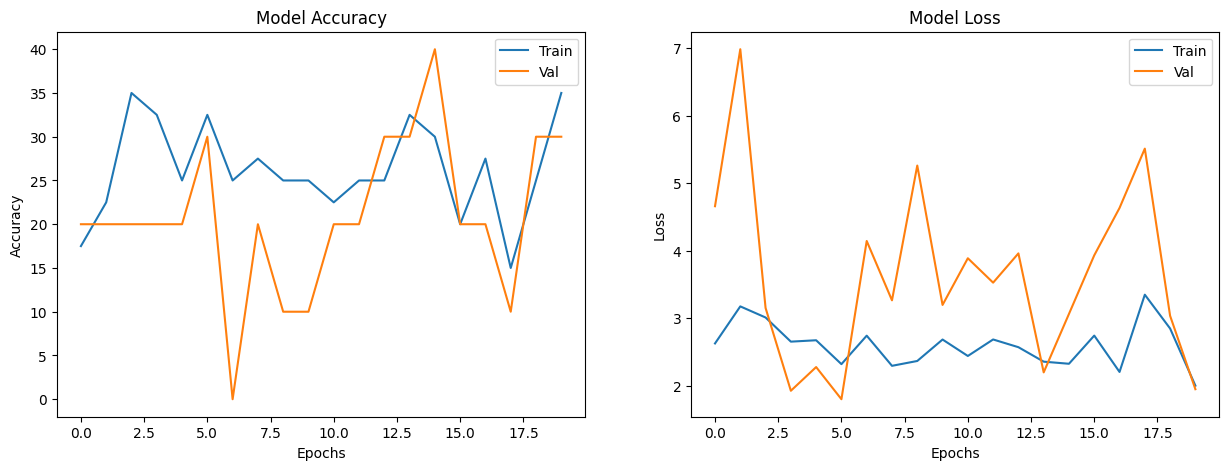

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

In [19]:
# Load the trained weights
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in val_loader:

        
        # images = (images) / 255.

      
        labels = labels.long()

        outputs = model(images)

        predicted = outputs.argmax(-1)
        print(predicted)
        print(labels)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')

idx: 0, img.shape: (3, 224, 224), img.dtype: uint8
idx: 1, img.shape: (3, 224, 224), img.dtype: uint8
idx: 2, img.shape: (3, 224, 224), img.dtype: uint8
idx: 3, img.shape: (3, 224, 224), img.dtype: uint8
idx: 4, img.shape: (3, 224, 224), img.dtype: uint8
idx: 5, img.shape: (3, 224, 224), img.dtype: uint8
idx: 6, img.shape: (3, 224, 224), img.dtype: uint8
idx: 7, img.shape: (3, 224, 224), img.dtype: uint8
tensor([3, 2, 3, 3, 3, 2, 3, 3])
tensor([0, 0, 1, 1, 2, 2, 3, 3])
idx: 8, img.shape: (3, 224, 224), img.dtype: uint8
idx: 9, img.shape: (3, 224, 224), img.dtype: uint8
tensor([4, 3])
tensor([4, 4])
Test accuracy is 40.0%
